<a id="S1_WASARD_top"></a>
# Water Across Synthetic Aperature Radar (WASARD)
WASARD is a general purpose transfer model between optical and SAR imagery for water classification.   
A trained WASARD model can be executed on SAR imagery to create water classification maps over a region.  

This notebook is inspired by an IGARSS publication titled [Water Across Synthetic Aperture Radar Data (WASARD): SAR Water Body Classification for the Open Data Cube](https://www.igarss2018.org/Papers/viewpapers.asp?papernum=3380) authored by Zachary Kreiser, Brian Killough, Syed R Rizvi.  


WASARD is trained using water classifications on optical imagery as a point of reference.  A machine learning model is used to approximate a transfer function between SAR data and Optical Classifications.  

>### Details regarding WASARD in this notebook  
> `Transfer Model:` Linear SVM
> `Optical water classifier:` WOfS
> `Optical Source:` Landsat 8
> `SAR Target`: Sentinel-1A

# In this notebook
* Existing coordinates are loaded for `Sentinel1` and `Landsat8` Imagery
* Upon comparison,coordinates are used to inform how data should be loaded.  
* `Sentinel1` imagery is loaded.
* `Landsat8`  imagery is loaded, reprojected, and upsampled to match the resolution of `Sentine1` 
* an existing water classifier is run on optical data.  
* optical water classifications are averaged across time and visualized
* a wasard model is created and trained  
* a wasard model is run on sentinel data
* the output of wasard is averaged across time and visualized 

<br>

# Index

* [Import Dependencies and Connect to the Data Cube](#S1_WASARD_import)
* [Choose Platforms and Products](#S1_WASARD_plat_prod)
* [Define the Extents of the Analysis](#S1_WASARD_define_extents)
* [Load and Clean Data from the Data Cube](#S1_WASARD_load_data)
    * Load the metadata for Sentinel-1 and Landsat
    * Investigate coordinates of Sentinel-1 and Landsat
    * Load the data
    * Compare reprojected coordinates for alignment
    * Clean Sentinel-1 data
    * Clean Landsat data
* [Get Landsat Water Classifications](#S1_WASARD_landsat_cls)
* [Get WASARD Water Classifications](#S1_WASARD_wasard_cls)

## <span id="S1_WASARD_import">Import Dependencies and Connect to the Data Cube [&#9652;](#S1_WASARD_top)</span>

In [1]:
import sys
import os
sys.path.append(os.environ.get('NOTEBOOK_ROOT'))

import xarray as xr  
import numpy as np
import matplotlib.pyplot as plt

from utils.data_cube_utilities.dc_display_map import display_map
from utils.data_cube_utilities.clean_mask import landsat_qa_clean_mask, landsat_clean_mask_invalid
import utils.data_cube_utilities.xarray_bokeh_plotting as xr_bokeh

from utils.data_cube_utilities.dc_rgb import rgb

import datacube
dc = datacube.Datacube()

## <span id="S1_WASARD_plat_prod">Choose Platforms and Products [&#9652;](#S1_WASARD_top)</span>

In [2]:
sar_product = "s1monthly_gamma0_ghana"
sar_platform = "SENTINEL1"
optical_product = "ls8_lasrc_ghana"
optical_platform = "LANDSAT_8"

## <span id="S1_WASARD_define_extents">Define the Extents of the Analysis [&#9652;](#S1_WASARD_top)</span>

In [3]:
# Sa'anapu, Samoa
# lat = (-14.0, -13.962341)
# lon = (-171.904492, -171.790327)

# Apia, Samoa
# lat = (-13.853425,-13.815715)
# lon = (-171.787842, -171.681356)

# Weija Reservoir, Ghana
lat = (5.5446, 5.6180)
lon = (-0.4127, -0.3255)
    
date_range = ('2016-8-1','2018-3-1')

In [4]:
display_map(latitude = lat, longitude = lon)

## <span id="S1_WASARD_load_data">Load and Clean Data from the Data Cube [&#9652;](#S1_WASARD_top)</span>

### Load the metadata for Sentinel-1 and Landsat

In [5]:
sentinel_coordinates =  dc.load(product = sar_product,
                                latitude = lat,
                                longitude = lon,
                                time = date_range,
                                measurements = [])
landsat_coordinates  =  dc.load(product = optical_product,
                                latitude = lat,
                                longitude = lon,
                                time = date_range,
                                measurements = [])

### Investigate coordinates of Sentinel-1 and Landsat

In [6]:
xr_bokeh.init_notebook() 

Loading BokehJS ...

In [7]:
xr_bokeh.dim_alignement( sentinel_coordinates.isel(latitude = slice(0,100), longitude = slice(0,100)), " Sentinel 1",
                          landsat_coordinates.isel(latitude = slice(0,100), longitude = slice(0,100)),  "Landsat 8")

### Load the data

In [8]:
sentinel_details = dc.list_products()[dc.list_products()["name"].str.contains(sar_product)]
sentinel_details

,name,description,product_type,time,creation_time,format,label,lon,platform,lat,instrument,crs,resolution,tile_size,spatial_dimensions
id,,,,,,,,,,,,,,,
21,s1monthly_gamma0_ghana,"Sentinel-1A/B SAR Gamma0, processed to the Yea...",gamma_0,None,None,NetCDF,None,None,SENTINEL1,None,SAR,EPSG:4326,"(-0.000180668, 0.000180668)","(0.99999738, 0.99999738)","(latitude, longitude)"


In [9]:
sentinel_crs        = str(sentinel_details['crs'].values[0])
sentinel_resolution = tuple(sentinel_details['resolution'].values[0])

In [10]:
sentinel_dataset = dc.load(product = sar_product,
                           latitude = lat,
                           longitude = lon,
                           time = date_range)

In [11]:
landsat_dataset = dc.load(product = optical_product,
                          time = date_range,
                          like=sentinel_dataset)

### Compare reprojected coordinates for alignment

In [12]:
subset_of_landsat_coords = landsat_dataset.isel(latitude = slice(0,100),
                                        longitude = slice(0,100),
                                        time = 0).coords

In [13]:
subset_of_sentinel_coords = sentinel_dataset.isel(latitude = slice(0,100),
                                        longitude = slice(0,100),
                                        time = 0).coords

In [14]:
xr_bokeh.dim_alignement(subset_of_sentinel_coords, "S1",
                        subset_of_landsat_coords, "LS")

### Clean Sentinel-1 data

In [15]:
def remove_all_zero(dataset):
    # Keep times with 1 or more non-zero values.
    times_to_keep = (dataset > 0).to_array().sum(dim=['latitude', 'longitude', 'variable']) > 0
    return dataset.sel(time=times_to_keep)

In [16]:
sentinel_dataset = remove_all_zero(sentinel_dataset)

### Clean Landsat data

In [17]:
landsat_clean_mask = (landsat_qa_clean_mask(landsat_dataset, optical_platform) & 
                      (landsat_dataset != -9999).to_array().all('variable') & 
                      landsat_clean_mask_invalid(landsat_dataset))

In [18]:
landsat_dataset = landsat_dataset.where(landsat_clean_mask)

In [19]:
landsat_median_composite = landsat_dataset.median('time')

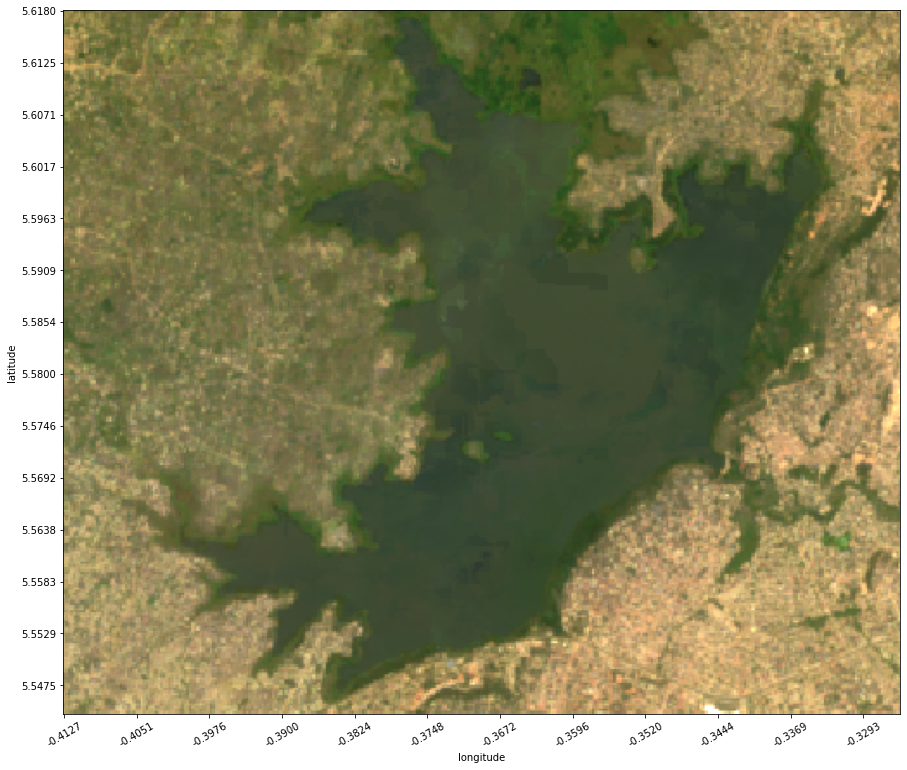

In [20]:
rgb(landsat_median_composite, bands=['red', 'green', 'blue'], width= 15,
    imshow_kwargs=dict(vmin=0, vmax=2000))
plt.show()

## <span id="S1_WASARD_landsat_cls">Get Landsat Water Classifications [&#9652;](#S1_WASARD_top)</span>

>### Import water classifier
> This notebooks uses WOFS. A water classification algorithm for landsat imagery, developed by Geoscience Australia. 

In [21]:
from utils.data_cube_utilities.dc_water_classifier import wofs_classify

>### Classify
> `wofs_classify` is used. An additional mask is passed in that indicates the presence of clouds

In [22]:
water_classifications = wofs_classify(landsat_dataset, clean_mask= landsat_clean_mask, no_data= np.nan)

>### Visualize Landsat water classifciaton
>A percentage (between the range of [0-1]) denotes the frequency of water in any given area, 

In [23]:
%matplotlib inline
def aspect_ratio_helper(x,y, fixed_width = 20):
    width = fixed_width
    height = y * (fixed_width / x)
    return (width, height)

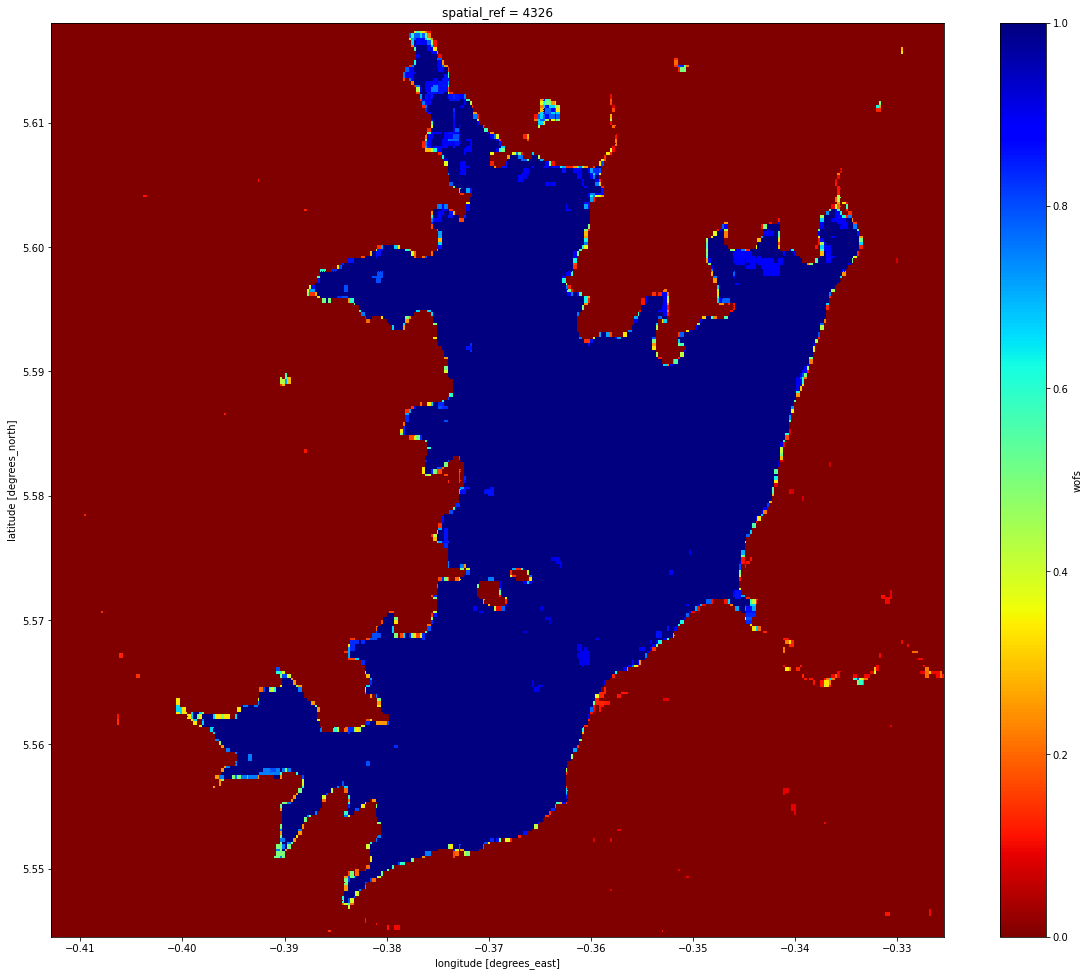

In [24]:
import matplotlib.pyplot as plt  

plt.figure(figsize = aspect_ratio_helper(*reversed(list(water_classifications.wofs.shape)[1:])))
water_classifications.mean(dim = 'time').wofs.plot(cmap = "jet_r")
plt.show()

## <span id="S1_WASARD_wasard_cls">Get WASARD Water Classifications [&#9652;](#S1_WASARD_top)</span>

>### Import wasard

In [25]:
from utils.data_cube_utilities import wasard

>### Train WASARD classifier
> In this case only data from samoa will be used. In the general case, It is suggested that a geographically varied dataset is used to train the model.

In [26]:
wasard_classifier = wasard.wasard_classifier(sar_dataset=sentinel_dataset,
                                             landsat_dataset=landsat_dataset)

/env/lib/python3.6/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


> ### Classify

In [27]:
wasard_classified = wasard_classifier.wasard_classify(sentinel_dataset)

>### Visualize WASARD SAR water classifciaton
>A percentage (between the range of [0-1]) denotes the frequency of water in any given area, 

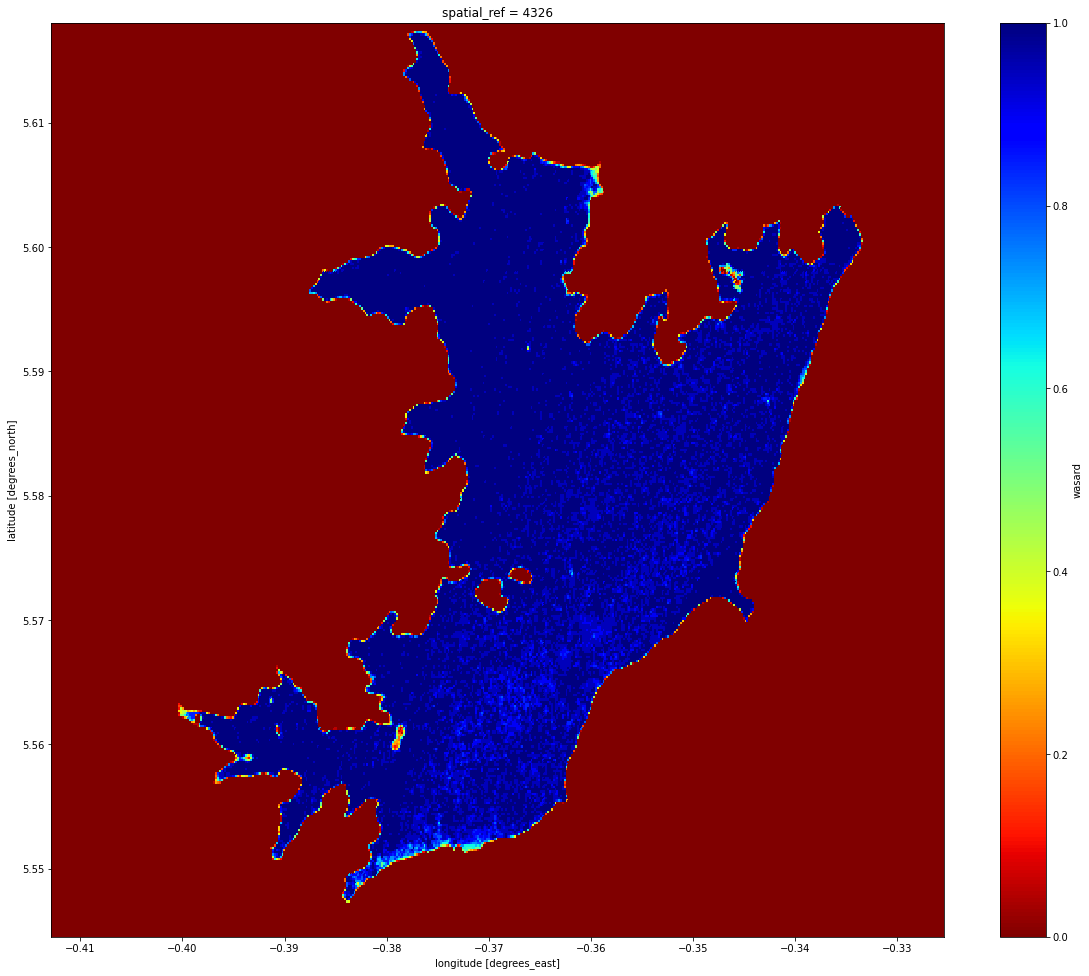

In [28]:
plt.figure(figsize = aspect_ratio_helper(*reversed(list(water_classifications.wofs.shape)[1:])))
wasard_classified.wasard.mean(dim = "time").plot(cmap = "jet_r")
plt.show()